<a href="https://colab.research.google.com/github/ITALOZDKJ/Me-tornando-um-analista-de-dados/blob/main/Comparativo_de_investimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando bibliotecas

In [101]:
!pip install yfinance
import pandas as pd
import numpy as np
import pandas_datareader as web
import yfinance as yf
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt


# Criando funções

### A seguir, temos uma função que cria features mais básicas, partindo das já disponíveis nos dados importados.

In [102]:
def features_initial(x):
    x.reset_index(inplace=True)
    x['Day'] = x['Date'].dt.day
    x['Month'] = x['Date'].dt.month
    x['Year'] = x['Date'].dt.year
    x['Year-Month'] = x['Date'].dt.strftime('%Y') +'-' + x['Date'].dt.strftime('%m') 
    x['Rentability%'] = round((x['Close']/x['Close'].shift()) * 100 -100, 2)
    x['Rentability pure'] = round(x['Close'] - x['Close'].shift(),2)

### Já a função abaixo, cria features um pouco mais elaboradas, nos permitindo simular um investimento feito de forma mensal e consistente, no período dos dados extraídos.

Com ela, conseguiremos informações como a quantidade de cotas totais em cada período, dividendos totais recebidos,
total de patrimônio acumuldado considerando a valorização do ativo e os dividendos recebidos ao longo do tempo.

In [103]:
def features_cash(x, y, aporte=100):
    x['Action_value'] = (x.loc[:,'High']+ x.loc[:,'Low'])/2
    year_temp = 0
    # 
    for year in list(x['Year'].unique()):
        year_temp = x.loc[(x['Year']==year)]
        for month in list(year_temp['Month'].unique()):
            temp = x.loc[(x['Month'] == month) & (x['Year']==year)]
            day = list(temp[0:]['Day'])
            day = day[0]
            x.loc[(x['Day'] == day) & (x['Month'] == month) & (x['Year'] == year),['Bougth']] = aporte
    # Valor de aporte
    x.loc[:,'Valor_aportado'] = x['Bougth'] * x['Action_value']
    x.fillna(0, inplace=True)
    # A soma das ações
    x['Total_actions'] = 0
    for pos,c in enumerate(x['Bougth']):
        x.loc[pos,'Total_actions'] = x.loc[:pos,'Bougth'].sum()
    
    # A soma do valor investido 
    x['Total_aportado'] = 0
    for pos,c in enumerate(x['Total_actions']):
        x.loc[pos,'Total_aportado'] = x.loc[:pos,'Valor_aportado'].sum()
        
    # The sum of dividends receives with actual aports
    x['Dividend_receive'] = x['Total_actions'] * x['Dividends']
    
    # The final dividends receives
    x['Total_receive'] = 0
    for pos,c in enumerate(x['Dividend_receive']):
        x.loc[pos,'Total_receive'] = x.loc[:pos,'Dividend_receive'].sum()

    x['Valor_atual'] = x['Total_actions'] * x['Close']


    x['My_rentability_pure'] = round(x['Valor_atual'] - x['Valor_atual'].shift(),2)

    x['yld_final'] = (x['Total_receive']/x['Total_aportado'])*100

def soma(x):
  x['Acumulatted'] = x['Valor_atual'] + x['Total_receive'] + x['Rentability pure']

## Importação de dados e aplicação das funções nos conjuntos de dados

In [100]:
ticket = yf.Ticker('TAEE4.SA')
bbseguros = yf.Ticker('BBSE3.SA')
itsa = yf.Ticker('ITSA4.SA')

In [104]:
taesa = ticket.history(interval='1d',start='2012-04-27', end='2022-04-27')
bbseguros = bbseguros.history(interval='1d',start='2012-04-27', end='2022-04-25')
itsa = itsa.history(interval='1d', start = '2012-04-27', end = '2022-04-27')

In [105]:
taesa_a = taesa.copy()
bbseguros_a = bbseguros.copy()
itsa_a = itsa.copy()
features_initial(taesa_a)
features_initial(bbseguros_a)
features_initial(itsa_a)

In [106]:
features_cash(bbseguros_a, bbseguros, aporte = 10)
features_cash(taesa_a, taesa, aporte=10)
features_cash(itsa_a, itsa, aporte=10)

In [107]:
soma(taesa_a)
soma(bbseguros_a)
soma(itsa_a)

## Resultados gerados

### Taesa
##### Ticker: TAEE4

In [108]:
taesa_a[taesa_a['Dividend_receive'] > 0][['Close','Rentability%', 'Total_aportado', 'My_rentability_pure', 'Valor_atual', 'Total_actions', 'Total_receive', 'Acumulatted', 'yld_final', 'Dividend_receive']].tail()

,Close,Rentability%,Total_aportado,My_rentability_pure,Valor_atual,Total_actions,Total_receive,Acumulatted,yld_final,Dividend_receive
881,9.541439,-2.51,2627.997540,-105.44,4102.818794,430,758.77397,4861.342764,28.872705,195.21140
901,10.050189,0.38,2725.943865,16.67,4422.083168,440,781.85637,5203.979538,28.682042,23.08240
992,12.402138,-1.59,3255.006918,-98.37,6077.047501,490,1048.28407,7125.131571,32.205279,266.42770
1002,12.542459,-0.07,3255.006918,-4.02,6145.805149,490,1269.49653,7415.291679,39.001347,221.21246
1140,11.950000,-2.56,4095.860700,-175.81,6691.999893,560,1552.88341,8244.573303,37.913482,283.38688


In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

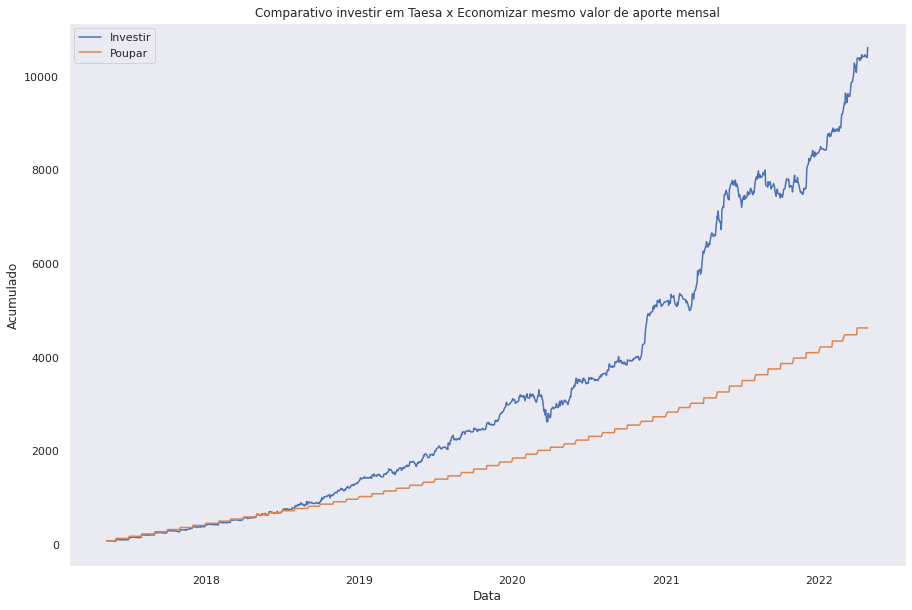

In [110]:
plt.figure(figsize=(15,10))
sns.set_theme(style="dark")
sns.lineplot(data = taesa_a, x='Date', y='Acumulatted')
sns.lineplot(data = taesa_a, x='Date', y='Total_aportado')
plt.title('Comparativo investir em Taesa x Economizar mesmo valor de aporte mensal')
plt.xlabel('Data')
plt.ylabel('Acumulado')
plt.legend(labels=['Investir','Poupar'])

In [111]:
taesa_a['Rentability%'].sum()

89.34

### Banco do Brasil seguros
##### Ticker: BBSE3

In [112]:
bbseguros_a[bbseguros_a['Dividend_receive'] > 0][['Close','Rentability%', 'Total_aportado', 'My_rentability_pure', 'Valor_atual', 'Total_actions', 'Total_receive', 'Acumulatted', 'yld_final', 'Dividend_receive']].tail()

,Close,Rentability%,Total_aportado,My_rentability_pure,Valor_atual,Total_actions,Total_receive,Acumulatted,yld_final,Dividend_receive
1691,30.867140,-2.40,15606.165128,-630.96,25619.726048,830,7963.42142,33582.387468,51.027407,1585.99803
1814,25.016768,-3.47,17059.642259,-800.83,22264.923077,890,8742.39837,31006.421447,51.246083,778.97695
1936,26.293934,-0.55,18555.340271,-137.23,24979.237175,950,9194.71332,34173.810495,49.552922,452.31495
2059,20.102053,-1.32,19870.787929,-271.16,20303.073215,1010,9720.79606,30023.599275,48.920033,526.08274
2184,22.760000,-2.86,21087.635426,-716.85,24353.200245,1070,10715.94742,35068.477665,50.816259,995.15136


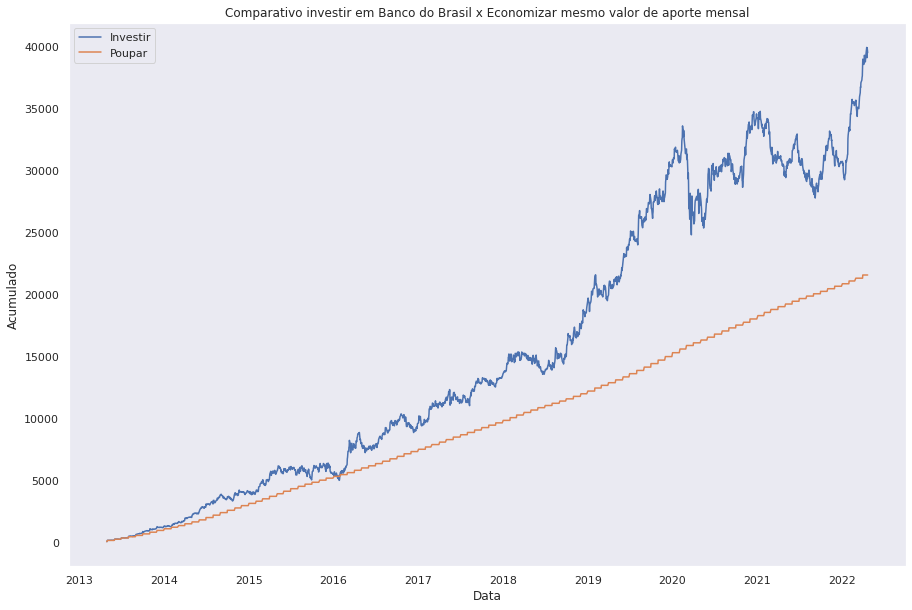

In [113]:
sns.set_theme(style="dark")
plt.figure(figsize=(15,10))
sns.lineplot(data = bbseguros_a, x='Date', y='Acumulatted')
sns.lineplot(data = bbseguros_a, x='Date', y='Total_aportado')
plt.title('Comparativo investir em Banco do Brasil x Economizar mesmo valor de aporte mensal')
plt.xlabel('Data')
plt.ylabel('Acumulado')
plt.legend(labels=['Investir','Poupar'])

In [114]:
bbseguros_a['Rentability%'].sum()

148.51999999999998

### Itaúsa
##### Ticker: ITSA4

In [115]:
itsa_a[itsa_a['Dividend_receive'] > 0][['Close','Rentability%', 'Total_aportado', 'My_rentability_pure', 'Valor_atual', 'Total_actions', 'Total_receive', 'Acumulatted', 'yld_final', 'Dividend_receive']].tail()

,Close,Rentability%,Total_aportado,My_rentability_pure,Valor_atual,Total_actions,Total_receive,Acumulatted,yld_final,Dividend_receive
2388,8.893707,0.77,7582.458382,79.62,10405.637512,1170,2976.18749,13381.895002,39.250957,26.21853
2410,9.399987,0.04,7670.449165,3.88,11091.984921,1180,3133.52869,14225.513611,40.851958,157.34120
2440,0.000000,0.00,7771.001446,-11748.80,0.000000,1200,3157.52869,3157.528690,40.632198,24.00000
2441,9.846700,0.00,7771.001446,11816.04,11816.039658,1200,3185.76349,15001.803148,40.995533,28.23480
2458,10.800000,-0.06,7771.001446,-7.96,12960.000229,1200,3321.80749,16281.797719,42.746196,136.04400


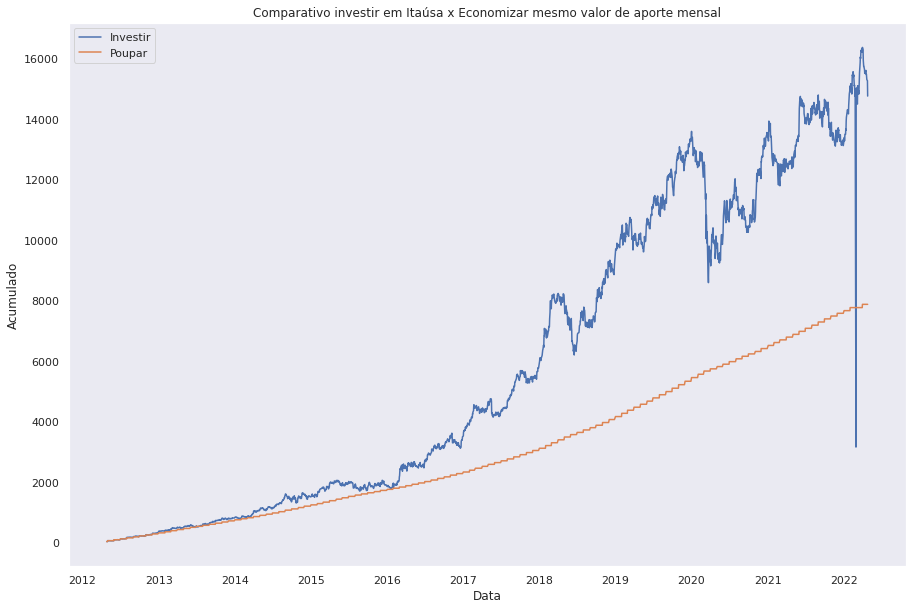

In [116]:
sns.set_theme(style="dark")
plt.figure(figsize=(15,10))
sns.lineplot(data = itsa_a, x='Date', y='Acumulatted')
sns.lineplot(data = itsa_a, x='Date', y='Total_aportado')
plt.title('Comparativo investir em Itaúsa x Economizar mesmo valor de aporte mensal')
plt.xlabel('Data')
plt.ylabel('Acumulado')
plt.legend(labels=['Investir','Poupar'])

## Alguns insights finais:

#### Yld máx Taesa: 39%
#### Yld máx Itaúsa: 42%
#### Yld máx Banco do Brasil: 51%
#### Yld final Taesa: 33.58%
#### Yld final Itaúsa: 42.16%
#### Yld final Banco do Brasil: 49.58%
#### Dividendo máximo por ação Taesa: 0.54
#### Dividendo máximo por ação Itaúsa: 0.57
#### Dividendo máximo por ação Banco do Brasil: 1.91



In [118]:
print(taesa_a['yld_final'].max())
print(itsa_a['yld_final'].max())
print(bbseguros_a['yld_final'].max())
print(taesa_a['Dividends'].max())
print(itsa_a['Dividends'].max())
print(bbseguros_a['Dividends'].max())
print(taesa_a['Dividend_receive'].max())
print(itsa_a['Dividend_receive'].max())
print(bbseguros_a['Dividend_receive'].max())

39.001346604742096
42.746195750011495
51.246082639615295
0.54373
0.579437
1.910841
283.38688
411.40027
1585.99803


In [120]:
taesa_a[['Total_aportado','Valor_atual', 'Total_receive','yld_final', 'Acumulatted']].tail()

,Total_aportado,Valor_atual,Total_receive,yld_final,Acumulatted
1230,4623.810696,8897.999954,1552.88341,33.584494,10450.933364
1231,4623.810696,8910.000229,1552.88341,33.584494,10462.903639
1232,4623.810696,8873.999977,1552.88341,33.584494,10426.823387
1233,4623.810696,8850.000000,1552.88341,33.584494,10402.843410
1234,4623.810696,9065.999794,1552.88341,33.584494,10619.243204


In [121]:
itsa_a[['Total_aportado','Valor_atual', 'Total_receive','yld_final', 'Acumulatted']].tail()

,Total_aportado,Valor_atual,Total_receive,yld_final,Acumulatted
2474,7879.001448,12160.500231,3321.80749,42.16026,15482.197721
2475,7879.001448,12172.600508,3321.80749,42.16026,15494.417998
2476,7879.001448,11991.099815,3321.80749,42.16026,15312.757305
2477,7879.001448,11954.800138,3321.80749,42.16026,15276.577628
2478,7879.001448,11446.600046,3321.80749,42.16026,14767.987536


In [122]:
bbseguros_a[['Total_aportado','Valor_atual', 'Total_receive','yld_final', 'Acumulatted']].tail()

,Total_aportado,Valor_atual,Total_receive,yld_final,Acumulatted
2226,21569.385428,28514.399834,10715.94742,49.681283,39230.567254
2227,21569.385428,29190.200748,10715.94742,49.681283,39906.768168
2228,21569.385428,28361.800499,10715.94742,49.681283,39076.987919
2229,21569.385428,29168.400249,10715.94742,49.681283,39885.087669
2230,21569.385428,28765.099335,10715.94742,49.681283,39480.676755
